# 33 MeV D on Ta 

This notebook documents the steps taken to calibrate, aquire, and analyze data from activation foils used to unfold the neutron spectrum from 33 MeV D breakup on Ta.  

This Notebook is broken into the following main sections: <br\>
1) Simulated Results <br\>
2) Simulated Unfold <br\>
3) Calibration <br\>
4) Count Plan <br\>
5) Experimental Setup <br\>

The notebook has dependecies on PScripts, which can be cloned from:
https://github.com/jamesbevins/PyScripts

In [1]:
import os
import sys
import peakutils

import pandas as pd
import numpy as np
import copy as cp

from math import sqrt, exp, log
from datetime import datetime
from scipy.optimize import curve_fit
from peakutils.plot import plot as pplot
from matplotlib import pyplot
%matplotlib inline

# Path to PyScripts support functions 
sys.path.insert(0,os.path.abspath('/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/GeneralNuclear'))
from Counting import parse_spe, simple_peak_counts, germanium_eff_exp, foil_count_time, volume_solid_angle, \
                     optimal_count_plan, germanium_eff_poly, ge_peakfit, get_peak_windows, find_best_fit, \
                     germanium_eff, channel_statistics
from BasicNuclearCalcs import decay, production_decay, get_decay_const, fractional_solid_angle
sys.path.insert(0,os.path.abspath('/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/DataAnalysis'))
from Stats import red_chisq, curve_fit_error4

## Simulated Results

### MCNP

The experimental configuration was simulated in MCNP to get the expected reaction rates.  The Meulder's deuterons on 197Au was used as the source, and the foil pack was suspended center beam 34.62 cm from the wall.

The results are located at <path>\Dropbox\UCB\Research\ETAs\88Inch\Data\Simulated\Activation\16MeVTa\Model

They are sumarized at:

In [2]:
simFoilPath = "/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Simulated/Activation/33MevTa/BeamOnly/33MeVTaFoils.xlsx"

## Simulated Unfold

Unfold of the MCNP results to test the theroretical ability to unfold given a set of reaction channels.  

## Calibration

### Import source data

Calibration was performed using Cs137, Co60, Eu 152, Am241, and Ba133 sources. The lines used for energy and efficiency calibration are:

#### Position 18 cm

Source   | Line (keV)| BR [%] | Time  | Filename
-------- |:---------:|:------:|:-----:|:----------------:
Cs137    |661.657    |85.10   |0733   |Cs137_18_0737_26Feb17
Co60     |1173.23    |99.85   |0746   |Co60_18_0759_26Feb17
Co60     |1332.49    |99.98   |0746   |Co60_18_0759_26Feb17
Am241    |59.54      |2.14    |0804   |Am241_18_0737_26Feb17
Ba133    |80.9979    |32.9    |0850   |Ba133_18_0921_26Feb17
Ba133    |276.40     |7.16    |0850   |Ba133_18_0921_26Feb17
Ba133    |302.85     |18.34   |0850   |Ba133_18_0921_26Feb17
Ba133    |356.01     |62.05   |0850   |Ba133_18_0921_26Feb17
Eu152    |121.70     |20.56   |0936   |Eu152_18_0737_26Feb17
Eu152    |244.70     |5.44    |0936   |Eu152_18_0737_26Feb17
Eu152    |344.29     |7.42    |0936   |Eu152_18_0737_26Feb17
Eu152    |778.90     |3.61    |0936   |Eu152_18_0737_26Feb17
Eu152    |964.06     |10.46   |0936   |Eu152_18_0737_26Feb17
Eu152    |1112.08    |9.85    |0936   |Eu152_18_0737_26Feb17
Eu152    |1408.01    |15.04   |0936   |Eu152_18_0737_26Feb17

#### Position 1 cm

The drawer was a little loose in the stack.  It was pushed to back right for repeatibility.

Source   | Line (keV)| BR [%] | Time  | Filename
-------- |:---------:|:------:|:-----:|:----------------:
Cs137    |661.657    |85.10   |1013   |Cs137_1_1015_26Feb17
Co60     |1173.23    |99.85   |1018   |Co60_1_1020_26Feb17
Co60     |1332.49    |99.98   |1018   |Co60_1_1020_26Feb17
Am241    |59.54      |2.14    |1024   |Am241_1_1025_26Feb17
Ba133    |80.9979    |32.9    |1029   |Ba133_1_0921_26Feb17
Ba133    |276.40     |7.16    |1029   |Ba133_1_0921_26Feb17
Ba133    |302.85     |18.34   |1029   |Ba133_1_0921_26Feb17
Ba133    |356.01     |62.05   |1029   |Ba133_1_0921_26Feb17
Eu152    |121.70     |20.56   |1036   |Eu152_1_1048_26Feb17
Eu152    |244.70     |5.44    |1036   |Eu152_1_1048_26Feb17
Eu152    |344.29     |7.42    |1036   |Eu152_1_1048_26Feb17
Eu152    |778.90     |3.61    |1036   |Eu152_1_1048_26Feb17
Eu152    |964.06     |10.46   |1036   |Eu152_1_1048_26Feb17
Eu152    |1112.08    |9.85    |1036   |Eu152_1_1048_26Feb17
Eu152    |1408.01    |15.04   |1036   |Eu152_1_1048_26Feb17

This data, along with the initial activity and decay information, is also located in the excel file located here:

In [3]:
calibSourcesPath = 'CalibrationSources.xlsx'

Import the source and activity data and format for later analysis:

In [4]:
sources = pd.read_excel(calibSourcesPath, "Sources")
sources.columns = ['source', 'initActivity', 'initActRelUncert', 'initDate', 'halfLife']
sources.index = sources.source
del sources['source']
sources['initDate'] = pd.to_datetime(sources['initDate'])
sources['measDate'] = 0     

print "The calibration source data used: \n\n", sources

The calibration source data used: 

        initActivity  initActRelUncert   initDate      halfLife  measDate
source                                                                   
Am241         10.300           0.01165 1970-01-01  1.364420e+10         0
Eu152          1.062           0.01165 2009-01-01  4.263262e+08         0
Co60           1.007           0.01165 2009-01-01  1.663442e+08         0
Cs137          1.042           0.01165 2009-01-01  9.487232e+08         0
Ba133          1.078           0.01165 2009-01-01  3.327363e+08         0


Import the calibration line and branching ratio data:

In [5]:
lines = pd.read_excel(calibSourcesPath,"Lines")
lines.columns=['isotope','line','branchingRatio']
print "The calibration peak data used: \n\n", lines

The calibration peak data used: 

      isotope       line  branchingRatio
0       Am241    59.5409        0.359000
1   Cs137       661.6570        0.851000
2   Co60       1173.2300        0.998500
3   Co60       1332.4900        0.999826
4   Ba133        80.9979        0.329000
5   Ba133       276.4000        0.071600
6   Ba133       302.8500        0.183400
7   Ba133       356.0100        0.620500
8   Eu152       121.7000        0.285300
9   Eu152       244.7000        0.075500
10  Eu152       344.2900        0.265900
11  Eu152       778.9000        0.129300
12  Eu152       964.0600        0.145100
13  Eu152      1085.8370        0.101100
14  Eu152      1112.0800        0.136700
15  Eu152      1408.0100        0.208700


### Perform software energy calibration

The energy calibration was performed using GammaVision.

[insert calibration procedure here]

### Read in the calibration data

Read in all of the data taken for calibration.  

This procedure assumes: <br/>
1) That there is a folder with only calibration data in the format "isotope_position_anything.Spe".  For example, a valid naming convention is "Co60_1_8Feb17.Spe".  The first field is used to compare against the imported lines, and the second field is to build a location dependent calibration. <br/>
2) Only calibration data lives in the calibration path specified.  <br/>
3) That the calibration order listed above in the table was followed. <br/>

The path the calibration data is:

In [6]:
calibDataPath = '/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/Activation/33MeVTa/BeamOnly/Calibration/'

# Variables to allow for multiple positions to be handled at once
posSet = False
posUsed = []

# Storage for parameters that vary by position
liveTime = {}
eCalibParams = {} #ax^2 +bx + c stored as (a,b,c)
data = {}

# Loop over all files
for filename in os.listdir(calibDataPath):
    if filename.endswith(".Spe"): 
        name = os.path.splitext(filename)[0]
        
        # Read data from this file
        print "Processing:", filename
        (time, t, measDate, a, b, c, tmpData) = parse_spe(calibDataPath+filename)
        
        # Determine position, update data structures if necessary, and store data
        position = int(name.split('_')[1])
        if position not in posUsed:
            posUsed.append(position)
            liveTime[position] = {}
            data[position] = tmpData
            data[position].columns = [name.split('_')[0]]
        else: 
            data[position].loc[:,name.split('_')[0]] = tmpData['counts']
        if name.split('_')[0] in sources.index:
            sources.at[name.split('_')[0], 'measDate'] = measDate
            liveTime[position][name.split('_')[0]] = time
            if name.split('_')[0] == "Ba133":
                eCalibParams[position] = (a, b, c)
for p in posUsed:
    print "\nPosition = {} cm".format(p)
    print "LiveTime:", liveTime[p]
    print "Energy Calibration: {}*ch^2 + {} * ch + {}".format(eCalibParams[p][0],eCalibParams[p][1],eCalibParams[p][2])
    print data[p].head(3)

Processing: Eu152_1.Spe
Processing: Y88_1.Spe
Processing: Eu152_5.Spe
Processing: Cs137_18.Spe
Processing: Co60_10.Spe
Processing: Cs137_5.Spe
Processing: Ba133_1.Spe
Processing: Co60_1.Spe
Processing: Y88_5.Spe
Processing: HEU_10.Spe
Processing: Cs137_1.Spe
Processing: Co60_18.Spe
Processing: Am241_10.Spe
Processing: Am241_1.Spe
Processing: Ba133_10.Spe
Processing: Y88_18.Spe
Processing: HEU_5.Spe
Processing: Eu152_18.Spe
Processing: Am241_18.Spe
Processing: HEU_18.Spe
Processing: HEU_1.Spe
Processing: Eu152_10.Spe
Processing: Ba133_18.Spe
Processing: Y88_10.Spe
Processing: Co60_5.Spe
Processing: Cs137_10.Spe
Processing: Am241_5.Spe
Processing: Ba133_5.Spe

Position = 1 cm
LiveTime: {'Co60': 42.0, 'Cs137': 21.0, 'Ba133': 115.0, 'Am241': 21.0, 'Eu152': 392.0}
Energy Calibration: 2.454251e-08*ch^2 + 0.3970808 * ch + -0.3404519
   Eu152  Y88  Ba133  Co60  Cs137  Am241  HEU
0      0    0      0     0      0      0    0
1      0    0      0     0      0      0    0
2      0    0      0    

### Calculate the peak counts

Determine the peak area for each of the lines considered.  Save the data in the lines dataframe. 

This procedure assumes: <br/>
1) That no significant background is present.  No background subtraction is performed. <br/>
2) A linear interpolation of the continuum is sufficient.  <br/>

There is an alternate, more sophisticated procedure immediately following this set of code.  This portion of code is redunant, but kept for now. If this peak fitting method is preferred, then change the cell to code and do not run the next peak fitting routine.   

# Create a dictionary of data frames to store each of the positional information
peakData = {}

for p in posUsed:
    print "\n------------------------"
    print "Position = {} cm".format(p)
    print "------------------------"
    # Update dataframe to store calculated peak information
    lines['measuredCounts'] = 0     
    lines['measUncert'] = 0
    for column in data[p]:
        
        # Find the peaks 
        channels = np.asarray(data[p].index)
        energy = eCalibParams[p][2]+eCalibParams[p][1]*channels+eCalibParams[p][0]*channels**2
        counts = np.asarray(data[p][column]).astype(float)
        peaks = peakutils.indexes(counts, thres=0.01, min_dist=10)
        
        # Loop over all identified peaks to compare against calibration points loaded previously
        print "\n", data[p][column].name, "\nEnergy  Counts     Area"      
        for i in range(len(lines['line'])):
            for e, c, pk in zip(energy[peaks], counts[peaks], peaks):
                # Calculate the total peak counts if a calibration peak
                if abs(e-lines['line'][i]) < 1 and data[p][column].name.strip() == lines['isotope'][i].strip():
                    (lines.at[i, 'measuredCounts'], lines.at[i, 'measUncert']) = simple_peak_counts(channels, counts, pk)
                    print "{:.2f}   {:.0f}   {:.2f}".format(e, c, lines.at[i, 'measuredCounts'])
            lines.at[i, 'isotope'] = lines.at[i, 'isotope'].strip()
        print "\n"
        
        # Plot the peaks found
        fig = pyplot.figure(figsize=(5,3))
        ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
        ax1.set_yscale('log')
        pplot(energy, counts, peaks)
        pyplot.title('Peaks @ {} cm for {}'.format(p,data[p][column].name))        
        pyplot.show()
        
    print lines
    peakData[p] = cp.deepcopy(lines)

### Calculate the peak counts

Determine the peak area for each of the lines considered.  Save the data in the lines dataframe. 

This procedure assumes: <br/>
1) That no significant background is present.  No background subtraction is performed. <br/>  


------------------------
Position = 1 cm
------------------------

Eu152 
Energy  Peak Area
121.96   330733   575
244.67   47381   217
344.34   168697   410

/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/DataAnalysis/Math.py:104: RuntimeWarning: overflow encountered in multiply
  return amplitude*(np.exp(rng*z))/(1+np.exp(z))**4
/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/DataAnalysis/Math.py:104: RuntimeWarning: overflow encountered in exp
  return amplitude*(np.exp(rng*z))/(1+np.exp(z))**4



779.22   38202   195
964.31   29683   172
1086.65   29068   170
1112.08   31073   176
1408.81   31954   178




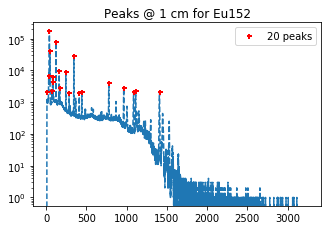


Y88 
Energy  Peak Area




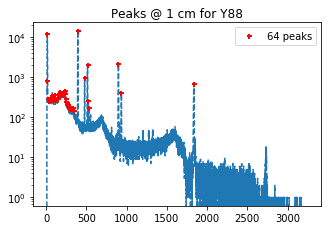


Ba133 
Energy  Peak Area
81.06   119327   345
276.44   10545   102
303.04   28671   169
356.26   84862   291




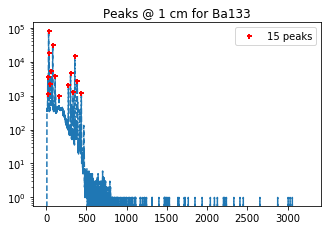


Co60 
Energy  Peak Area
1173.64   12593   112
1332.94   11168   105




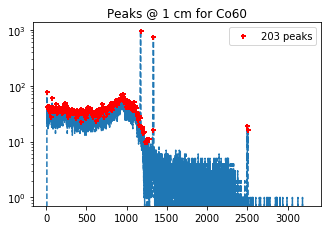


Cs137 
Energy  Peak Area
662.06   24522   156




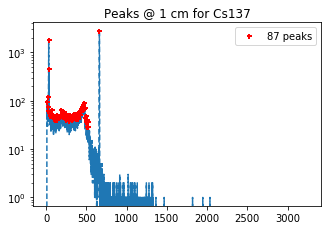


Am241 
Energy  Peak Area
59.62   428652   654




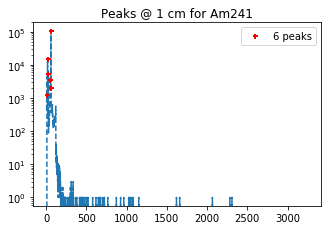


HEU 
Energy  Peak Area




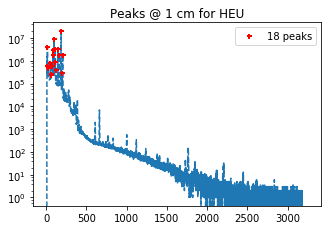

   isotope       line  branchingRatio  measuredCounts  measUncert
0    Am241    59.5409        0.359000          428652         654
1    Cs137   661.6570        0.851000           24522         156
2     Co60  1173.2300        0.998500           12593         112
3     Co60  1332.4900        0.999826           11168         105
4    Ba133    80.9979        0.329000          119327         345
5    Ba133   276.4000        0.071600           10545         102
6    Ba133   302.8500        0.183400           28671         169
7    Ba133   356.0100        0.620500           84862         291
8    Eu152   121.7000        0.285300          330733         575
9    Eu152   244.7000        0.075500           47381         217
10   Eu152   344.2900        0.265900          168697         410
11   Eu152   778.9000        0.129300           38202         195
12   Eu152   964.0600        0.145100           29683         172
13   Eu152  1085.8370        0.101100           29068         170
14   Eu152

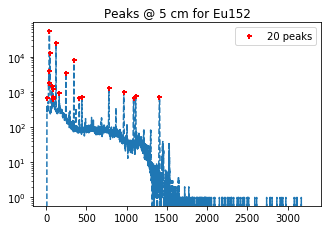


Cs137 
Energy  Peak Area
661.70   165352   406




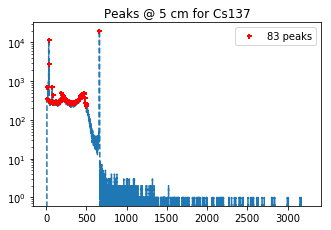


Y88 
Energy  Peak Area




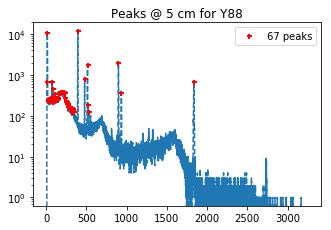


HEU 
Energy  Peak Area




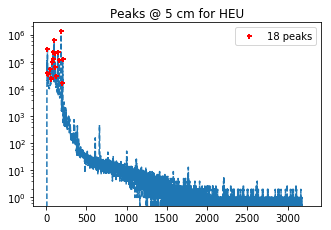


Co60 
Energy  Peak Area
1173.72   11818   108
1333.01   10231   101




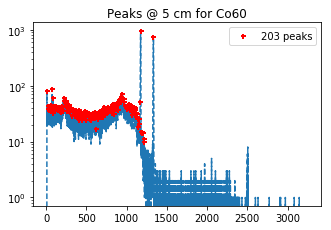


Am241 
Energy  Peak Area
59.50   63021   251




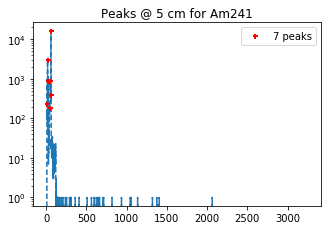


Ba133 
Energy  Peak Area
80.95   101829   319
276.39   18624   136
303.00   24927   157
356.23   75562   274




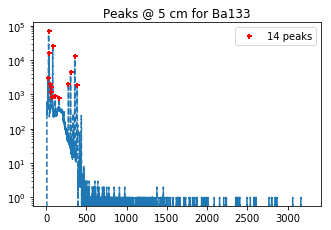

   isotope       line  branchingRatio  measuredCounts  measUncert
0    Am241    59.5409        0.359000           63021         251
1    Cs137   661.6570        0.851000          165352         406
2     Co60  1173.2300        0.998500           11818         108
3     Co60  1332.4900        0.999826           10231         101
4    Ba133    80.9979        0.329000          101829         319
5    Ba133   276.4000        0.071600           18624         136
6    Ba133   302.8500        0.183400           24927         157
7    Ba133   356.0100        0.620500           75562         274
8    Eu152   121.7000        0.285300          101636         318
9    Eu152   244.7000        0.075500           17463         132
10   Eu152   344.2900        0.265900           47265         217
11   Eu152   778.9000        0.129300           11466         107
12   Eu152   964.0600        0.145100            9959          99
13   Eu152  1085.8370        0.101100            8461          91
14   Eu152

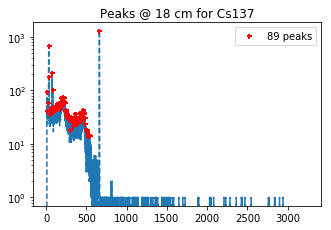


Co60 
Energy  Peak Area
1174.56   11363   106
1333.80   10250   101




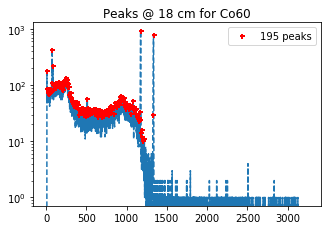


Y88 
Energy  Peak Area




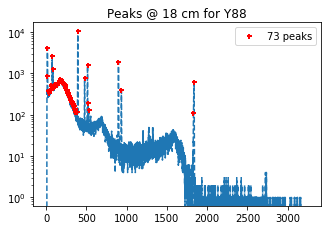


Eu152 
Energy  Peak Area
121.87   121726   348
244.97   23220   152
344.24   59085   243
779.05   14844   121
963.70   13698   117
1085.21   10572   102
1112.22   11804   108
1408.06   14877   121




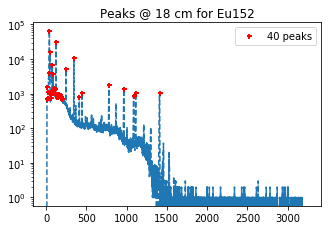


Am241 
Energy  Peak Area
59.53   30768   175




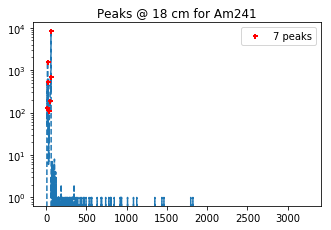


HEU 
Energy  Peak Area




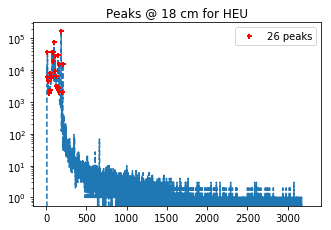


Ba133 
Energy  Peak Area
80.98   94103   306
276.34   10727   103
302.94   25587   159
356.15   75272   274




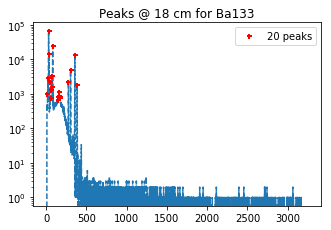

   isotope       line  branchingRatio  measuredCounts  measUncert
0    Am241    59.5409        0.359000           30768         175
1    Cs137   661.6570        0.851000           10329         101
2     Co60  1173.2300        0.998500           11363         106
3     Co60  1332.4900        0.999826           10250         101
4    Ba133    80.9979        0.329000           94103         306
5    Ba133   276.4000        0.071600           10727         103
6    Ba133   302.8500        0.183400           25587         159
7    Ba133   356.0100        0.620500           75272         274
8    Eu152   121.7000        0.285300          121726         348
9    Eu152   244.7000        0.075500           23220         152
10   Eu152   344.2900        0.265900           59085         243
11   Eu152   778.9000        0.129300           14844         121
12   Eu152   964.0600        0.145100           13698         117
13   Eu152  1085.8370        0.101100           10572         102
14   Eu152

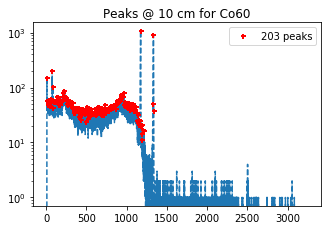


HEU 
Energy  Peak Area




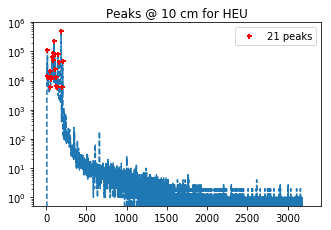


Am241 
Energy  Peak Area
59.49   26754   163




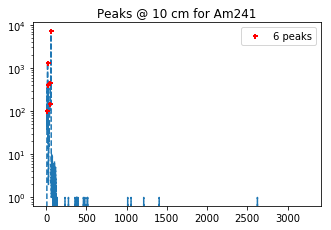


Ba133 
Energy  Peak Area
80.94   95610   309
276.37   18068   134
302.98   25166   158
356.21   74898   273




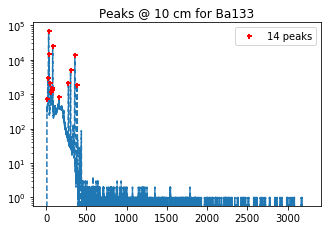


Eu152 
Energy  Peak Area
121.86   75012   273
244.59   13592   116
344.29   35736   189
779.25   8755   93
963.96   8147   90
1086.31   6453   80
1112.13   7119   84
1408.47   8787   93




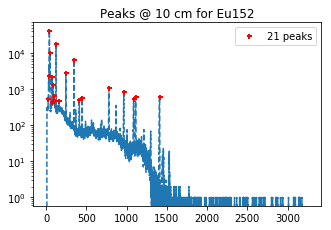


Y88 
Energy  Peak Area




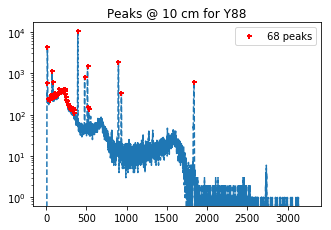


Cs137 
Energy  Peak Area
662.07   10359   101




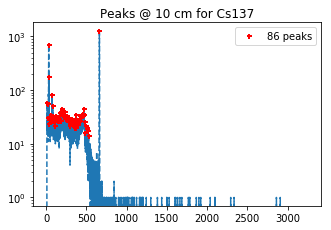

   isotope       line  branchingRatio  measuredCounts  measUncert
0    Am241    59.5409        0.359000           26754         163
1    Cs137   661.6570        0.851000           10359         101
2     Co60  1173.2300        0.998500           13112         114
3     Co60  1332.4900        0.999826           11984         109
4    Ba133    80.9979        0.329000           95610         309
5    Ba133   276.4000        0.071600           18068         134
6    Ba133   302.8500        0.183400           25166         158
7    Ba133   356.0100        0.620500           74898         273
8    Eu152   121.7000        0.285300           75012         273
9    Eu152   244.7000        0.075500           13592         116
10   Eu152   344.2900        0.265900           35736         189
11   Eu152   778.9000        0.129300            8755          93
12   Eu152   964.0600        0.145100            8147          90
13   Eu152  1085.8370        0.101100            6453          80
14   Eu152

In [7]:
# Create a dictionary of data frames to store each of the positional information
peakData = {}
for p in posUsed:
    print "\n------------------------"
    print "Position = {} cm".format(p)
    print "------------------------"
    
    # Update dataframe to store calculated peak information
    lines['measuredCounts'] = 0     
    lines['measUncert'] = 0
    
    for column in data[p]:    
        # Find the peaks and set the windows
        channels = np.asarray(data[p].index)
        counts = np.asarray(data[p][column]).astype(float)
        energy = eCalibParams[p][2]+eCalibParams[p][1]*channels+eCalibParams[p][0]*channels**2
        peaks = peakutils.indexes(counts, thres=0.01, min_dist=10)
        windows = get_peak_windows(peaks)
        
        # Loop over all identified peaks to compare against calibration points loaded previously
        print "\n", data[p][column].name, "\nEnergy  Peak Area"      
        for i in range(len(lines['line'])):
            for e, pk in zip(energy[peaks], peaks):
                # Calculate the total peak counts if a calibration peak
                if abs(e-lines['line'][i]) < 1.5 and data[p][column].name.strip() == lines['isotope'][i].strip():
                    pkChannels = channels[windows[pk][0]:windows[pk][1]]
                    pkCounts = counts[windows[pk][0]:windows[pk][1]]
                    (lines.at[i, 'measuredCounts'], lines.at[i, 'measUncert'], redChiSq) = \
                                 ge_peakfit(pkChannels, pkCounts)
                    
                    print "{:.2f}   {:.0f}   {:.0f}".format(e, lines.at[i, 'measuredCounts'], lines.at[i, 'measUncert'])
            lines.at[i, 'isotope'] = lines.at[i, 'isotope'].strip()
        print "\n"
        
        # Plot the peaks found
        fig = pyplot.figure(figsize=(5,3))
        ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
        ax1.set_yscale('log')
        pplot(energy, counts, peaks)
        pyplot.title('Peaks @ {} cm for {}'.format(p,data[p][column].name))        
        pyplot.show()
        
    print lines
    peakData[p] = cp.deepcopy(lines)

####TMP#### - Can remove once satisfied that peak fitting is working correctly
# Find the peaks 
channels = np.asarray(data[18].index)
energy = eCalibParams[18][2]+eCalibParams[18][1]*channels+eCalibParams[18][0]*channels**2
counts = np.asarray(data[18]['Eu152']).astype(float)
peaks = peakutils.indexes(counts, thres=0.015, min_dist=10)
print peaks

window = get_peak_windows(peaks)
#peaks = [210, 720, 927] # Ba133
#peaks = [317, 637, 896, 2028, 2510, 2897, 3666] #Eu152@1
#peaks = [317, 637, 897, 2028, 2510, 2897, 3666] #Eu152@10
peaks = [317, 638, 897, 2029, 2511, 2897, 3668] #Eu152@18
peaks = [638] #Eu152@18
#peaks = [3055, 3469]

# Loop over all identified peaks to compare against calibration points loaded previously
for pk in peaks:
    pkChannels = channels[window[pk][0]:window[pk][1]]
    pkCounts = counts[window[pk][0]:window[pk][1]]
    (peakCounts, peakStd, redChiSq) = ge_peakfit(pkChannels, pkCounts)
    
    print "{:.2f}   {:.2f}   {:.2f}".format(energy[pk], peakCounts, peakStd)

## Propogation of fitting error?
import sys
import os
sys.path.insert(0,os.path.abspath('/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/DataAnalysis'))
from Math import gaussScalar
#from sympy import symbols, diff
import theano
#x, a, b, c = symbols('x a b c')
#print diff(gaussScalar(x, a, b, c), x)

### Calculate the current activity

Using the data read in from the .spe files, calculate the current activity at the time of the measurement.  

NOTE:  There is a mix in the activity units.  The initActivity is in $\mu$Ci as reported on the source, whereas the curActivity in is Bq.

In [8]:
sources['curActivity'] = 0
for src in sources.index:
    sources.at[src, 'curActivity'] = decay(sources.at[src, 'halfLife'],sources.at[src, 'initActivity'], \
                                        (sources.at[src, 'measDate']-sources.at[src, 'initDate']).total_seconds())
print sources   

        initActivity  initActRelUncert   initDate      halfLife  \
source                                                            
Am241         10.300           0.01165 1970-01-01  1.364420e+10   
Eu152          1.062           0.01165 2009-01-01  4.263262e+08   
Co60           1.007           0.01165 2009-01-01  1.663442e+08   
Cs137          1.042           0.01165 2009-01-01  9.487232e+08   
Ba133          1.078           0.01165 2009-01-01  3.327363e+08   

                   measDate  curActivity  
source                                    
Am241   2017-03-29 19:34:13       353302  
Eu152   2017-03-29 20:09:44        25745  
Co60    2017-03-29 19:23:29        12607  
Cs137   2017-03-29 19:46:10        31882  
Ba133   2017-03-29 23:03:41        23202  


### Calculate absolute effficiency

Determine an absolute efficiency curve for each position by curve fitting the experimental data. The germanium_eff_exp function has support for propogation of error, but the germanium_eff, or germanium_eff_poly are also available.  

NOTE: The choice of which functions to onsider can be set with the functions list.

NOTE: The uncertainty only currently captures the uncertainity in the counts and initial activity.  The uncertaities in BR, half lives, and measurement time are sufficiently small that they can be ignored, but there is uncertainty associated with the fit of the peak that is not captured if germanium_eff_exp is not used.  

The fitting function was: germanium_eff
The curve fitting parameters at 1 cm are: [ 0.03728354  0.01808428  0.21558398 -0.01692042]
  with standard deviations at 1 cm of: [ 0.00183911  0.00129466  0.02268822  0.00126505]

   isotope       line  expectedCounts  absEfficiency  effUncert
0    Am241    59.5409    2.663544e+06       0.160933   0.001875
1    Cs137   661.6570    5.697632e+05       0.043039   0.000501
2     Co60  1173.2300    5.286998e+05       0.023819   0.000278
3     Co60  1332.4900    5.294019e+05       0.021096   0.000246
4    Ba133    80.9979    8.778477e+05       0.135931   0.001584
5    Ba133   276.4000    1.910453e+05       0.055196   0.000643
6    Ba133   302.8500    4.893534e+05       0.058590   0.000683
7    Ba133   356.0100    1.655637e+06       0.051256   0.000597
8    Eu152   121.7000    2.879259e+06       0.114867   0.001338
9    Eu152   244.7000    7.619490e+05       0.062184   0.000724
10   Eu152   344.2900    2.683473e+06       0.062865   0.000732
11   Eu152

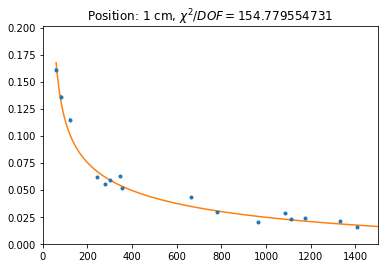

The fitting function was: germanium_eff_exp
The curve fitting parameters at 5 cm are: [  3.92191639e-01   8.30436184e-01   1.38223588e+03  -1.19358439e+00]
  with standard deviations at 5 cm of: [  2.53744696e-02   9.36936717e-03   8.14445645e+02   1.47249650e-01]

   isotope       line  expectedCounts  absEfficiency  effUncert
0    Am241    59.5409    1.395190e+06       0.045170   0.000526
1    Cs137   661.6570    1.435261e+07       0.011521   0.000134
2     Co60  1173.2300    1.623864e+06       0.007278   0.000085
3     Co60  1332.4900    1.626020e+06       0.006292   0.000073
4    Ba133    80.9979    2.274770e+06       0.044765   0.000522
5    Ba133   276.4000    4.950564e+05       0.037620   0.000438
6    Ba133   302.8500    1.268064e+06       0.019658   0.000229
7    Ba133   356.0100    4.290259e+06       0.017612   0.000205
8    Eu152   121.7000    2.666253e+06       0.038119   0.000444
9    Eu152   244.7000    7.055803e+05       0.024750   0.000288
10   Eu152   344.2900    2.484

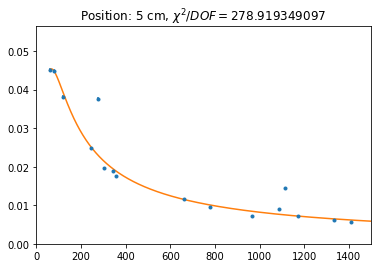

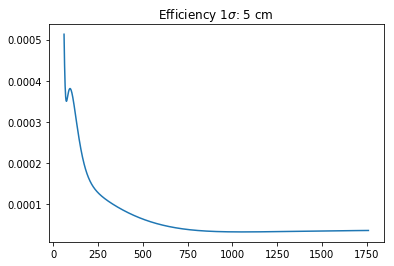

The fitting function was: germanium_eff_exp
The curve fitting parameters at 18 cm are: [  3.32121460e+00   7.95517305e-01   2.14553866e+05  -1.90262072e+00]
  with standard deviations at 18 cm of: [  1.45943354e-01   6.57915128e-03   1.25186842e+05   1.43131794e-01]

   isotope       line  expectedCounts  absEfficiency  effUncert
0    Am241    59.5409    5.453923e+06       0.005641   0.000066
1    Cs137   661.6570    6.158869e+06       0.001677   0.000020
2     Co60  1173.2300    1.039776e+07       0.001093   0.000013
3     Co60  1332.4900    1.041157e+07       0.000984   0.000011
4    Ba133    80.9979    1.458754e+07       0.006451   0.000075
5    Ba133   276.4000    3.174674e+06       0.003379   0.000039
6    Ba133   302.8500    8.131777e+06       0.003147   0.000037
7    Ba133   356.0100    2.751236e+07       0.002736   0.000032
8    Eu152   121.7000    2.215267e+07       0.005495   0.000064
9    Eu152   244.7000    5.862342e+06       0.003961   0.000046
10   Eu152   344.2900    2.0

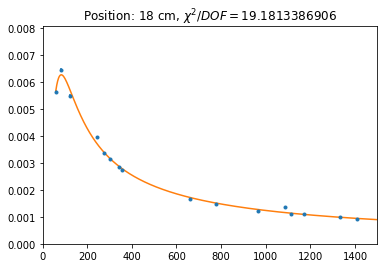

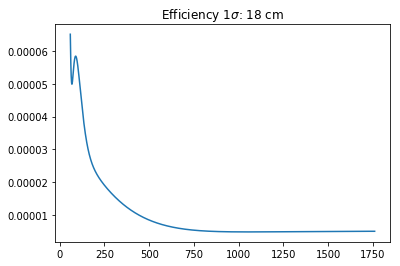

The fitting function was: germanium_eff_exp
The curve fitting parameters at 10 cm are: [  8.07986497e-01   8.63232877e-01   3.69931428e+03  -1.14709483e+00]
  with standard deviations at 10 cm of: [  5.51199170e-02   9.84154624e-03   1.72271451e+03   1.16050176e-01]

   isotope       line  expectedCounts  absEfficiency  effUncert
0    Am241    59.5409    1.648860e+06       0.016226   0.000189
1    Cs137   661.6570    2.333316e+06       0.004440   0.000052
2     Co60  1173.2300    4.733122e+06       0.002770   0.000032
3     Co60  1332.4900    4.739407e+06       0.002529   0.000029
4    Ba133    80.9979    5.610592e+06       0.017041   0.000199
5    Ba133   276.4000    1.221028e+06       0.014797   0.000172
6    Ba133   302.8500    3.127606e+06       0.008046   0.000094
7    Ba133   356.0100    1.058168e+07       0.007078   0.000082
8    Eu152   121.7000    5.192949e+06       0.014445   0.000168
9    Eu152   244.7000    1.374229e+06       0.009891   0.000115
10   Eu152   344.2900    4.8

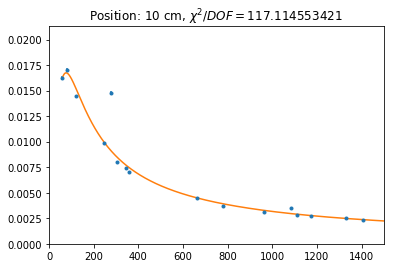

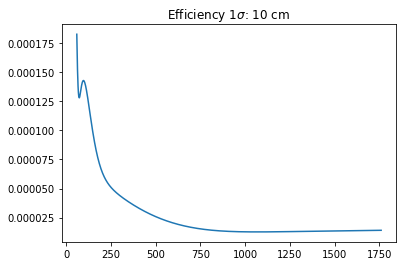

In [9]:
from Counting import germanium_eff
functions=[germanium_eff, germanium_eff_exp]#, germanium_eff_poly]
absEffParams = {}
absEffCov = {}
fitFunc = {} 

for p in posUsed:
    peakData[p]['expectedCounts'] = 0.0
    peakData[p]['absEfficiency'] = 0.0
    peakData[p]['effUncert'] = 0.0
    
    # Calculate the absolute efficiency and uncertainty
    for index, row in peakData[p].iterrows():
        peakData[p].at[index, 'expectedCounts'] = sources.at[peakData[p].at[index, 'isotope'], 'curActivity'] \
                                               * peakData[p].at[index, 'branchingRatio'] \
                                               * liveTime[p][peakData[p].at[index, 'isotope']]
        peakData[p].at[index, 'absEfficiency'] = float(peakData[p].at[index, 'measuredCounts']) \
                                               / float(peakData[p].at[index, 'expectedCounts'])
        peakData[p].at[index, 'effUncert'] = peakData[p].at[index, 'absEfficiency'] * \
                                           sqrt((peakData[p].at[index, 'measUncert'] \
                                           / peakData[p].at[index, 'measuredCounts'])**2 \
                                               + sources.at[peakData[p].at[index, 'isotope'], 'initActRelUncert']**2)
    
    # Fit the data for the current position by finding best fitting routine
    (fitFunc[p], absEffParams[p], absEffCov[p], redChiSq) = find_best_fit(*functions,
                                                     xdata=peakData[p]['line'], ydata=peakData[p]['absEfficiency'],
                                                     sigma=peakData[p]['effUncert'], absolute_sigma=True)
    
    # Output the results
    try:
        print 'The fitting function was: {}'.format(fitFunc[p].__name__)
        print 'The curve fitting parameters at {} cm are: {}'.format(p, absEffParams[p])
        print '  with standard deviations at {} cm of: {}\n'.format(p, np.sqrt(np.diag(absEffCov[p])))
        print peakData[p][['isotope', 'line', 'expectedCounts', 'absEfficiency', 'effUncert']]

        #Plot the Data
        pyplot.axis([0, 1500, 0, 1.25*max(peakData[p]['absEfficiency'])])
        pyplot.errorbar(peakData[p]['line'], peakData[p]['absEfficiency'], peakData[p]['effUncert'], fmt='.')
        pyplot.title('Position: {} cm, $\chi^2/DOF={}$'.format(p, redChiSq))

        #Plot the fit
        xList = np.arange(min(peakData[p]['line']), 1.25*max(peakData[p]['line']), 1)
        yList = map(lambda y: fitFunc[p](y, *absEffParams[p]), xList)
        pyplot.plot(xList, yList)
        pyplot.show()

        #Plot the error
        if fitFunc[p] == germanium_eff_exp:
            pyplot.title('Efficiency 1$\sigma$: {} cm'.format(p))
            xList = np.arange(min(peakData[1]['line']), 1.25*max(peakData[1]['line']), 1)
            yList = map(lambda y: curve_fit_error4(fitFunc[p], np.insert(absEffParams[p], 0, y), y*0.001, 
                                                   absEffCov[p]), xList)
            pyplot.plot(xList, yList)
            pyplot.show()
    except AttributeError:
        print 'No fit was found'
        print peakData[p][['isotope', 'line', 'expectedCounts', 'absEfficiency', 'effUncert']]
        
        #Plot the Data
        pyplot.axis([0, 1500, 0, 1.25*max(peakData[p]['absEfficiency'])])
        pyplot.errorbar(peakData[p]['line'], peakData[p]['absEfficiency'], peakData[p]['effUncert'], fmt='.')
        pyplot.title('Position: {} cm, $\chi^2/DOF={}$'.format(p, redChiSq))
        pyplot.show()

## Count Plan

Develop a count plan based on the planned irradiation. This assumes that you have a priori abs effeciency calibration parameters for the position of interest. 

### Vault Activation Foils

#### Experimental parameters

Specifies experimental parameters for the beam and counting facility used.

runTime = the beam irradiation time in s

transitTime = the minimum time to counting of the first foil in s

background = the background rate at the peak of interest in counts/s

detR = radius of the detector in cm

In [20]:
runTime = 1200
transitTime = 600

background = 0.01
detR = 3.245

#### Read in Simulation data

Read from the designated file path.  Manipulate the file to build a dataframe with the information needed for the count plan.  

In [27]:
simVaultFoils = pd.read_excel(simFoilPath, sheetname='Vault')

# Delete unneccesary columns for readability and make the index the reactant
simVaultFoils.index = simVaultFoils.Rx
del simVaultFoils['Rx']
del simVaultFoils['Thickness [cm]']
del simVaultFoils['Density']
del simVaultFoils['AW']
del simVaultFoils['Lambda [s^-1]']

# Rename columns for ease of access and add in the statistics column
simVaultFoils.columns = ['foil', 'product', 'gammaEnergy', 'br', 'relStat', 'det2FoilDist', 'normalization', 'rxRate',
                         'rxRateSigma', 'foilR','weightFrac', 'volume', 'halfLife']

# Put branching ratios in fractional form
simVaultFoils['br'] = simVaultFoils['br']/100.

# Calculate the activity following transit time decay for each rx; delete columns no longer needed
simVaultFoils['initActivity'] = 0.0
simVaultFoils['activityUncert'] = 0.0
for ind in simVaultFoils.index:
    simVaultFoils.at[ind,'initActivity'] = production_decay(simVaultFoils.at[ind, 'halfLife'], 0, runTime, \
                                                    simVaultFoils.at[ind, 'rxRate'], \
                                                    simVaultFoils.at[ind, 'normalization'], \
                                                    simVaultFoils.at[ind, 'volume'], transitTime)\
                                                    *get_decay_const(simVaultFoils.at[ind,'halfLife'])\
                                                    *simVaultFoils.at[ind,'br']
    simVaultFoils.at[ind,'activityUncert'] = simVaultFoils.at[ind, 'initActivity']*simVaultFoils.at[ind, 'rxRateSigma']
del simVaultFoils['rxRate']
del simVaultFoils['normalization']
del simVaultFoils['volume']
del simVaultFoils['rxRateSigma']

print simVaultFoils

               foil product  gammaEnergy      br  relStat  det2FoilDist  \
Rx                                                                        
115In(n,n')      In  In115M      336.241  0.4580     0.01             1   
115In(n,g)       In  In116M     1293.560  0.8480     0.01             1   
27Al(n,p)        Al    Mg27      843.760  0.7180     0.01             1   
27Al(n,a)        Al    Na24     1368.630  0.9999     0.01             1   
197Au(n,2n)      Au   Au196      355.700  0.8090     0.01             1   
197Au(n,g)       Au   Au198      411.800  0.9562     0.01             1   
115In(n,n')18  In18  In115M      336.241  0.4580     0.01            18   
115In(n,g)18   In18  In116M     1293.560  0.8480     0.01            18   
27Al(n,p)18    Al18    Mg27      843.760  0.7180     0.01            18   
27Al(n,a)18    Al18    Na24     1368.630  0.9999     0.01            18   
197Au(n,2n)18  Au18   Au196      355.700  0.8090     0.01            18   
197Au(n,g)18   Au18   Au1

In [28]:
(simVaultFoils,countOrder,countTime) = optimal_count_plan(simVaultFoils, handleTime=75, detR=detR, background=background, 
                                                    units='Bq', toMinute = True, 
                                                    funcDict=fitFunc, funcParamDict=absEffParams )
print 'Total count time = {:2e} hrs\n'.format(countTime/3600)
print 'The order of counting is: {}\n'.format(countOrder)
for ind in simVaultFoils.index:
    print "{:15s} {:4.0f} min".format(ind, simVaultFoils.at[ind,"countTime"]/60)

Total count time = 2.777778e+95 hrs

The order of counting is: (u'Al18', u'Al', u'Au', u'In18', u'In', u'Au18')

27Al(n,p)18        4 min
27Al(n,a)18        4 min
27Al(n,p)          1 min
27Al(n,a)          1 min
197Au(n,2n)      215 min
197Au(n,g)       215 min
115In(n,n')18     36 min
115In(n,g)18      36 min
115In(n,n')        3 min
115In(n,g)         3 min
197Au(n,2n)18   16666666666666665363414444042936102902910745743838851641442524819779596943039575155886178065973248 min
197Au(n,g)18    16666666666666665363414444042936102902910745743838851641442524819779596943039575155886178065973248 min


### Cave Activation Foils

#### Experimental Parameters

In [29]:
runTime = 3600*4
transitTime = 360

background = 0.01
detR = 3.245

#### Read in Simulation data

Read from the designated file path.  Manipulate the file to build a dataframe with the information needed for the count plan.  

In [30]:
simCaveFoils = pd.read_excel(simFoilPath, sheetname='Cave')

# Delete unneccesary columns for readability and make the index the reactant
simCaveFoils.index = simCaveFoils.Rx
del simCaveFoils['Rx']
del simCaveFoils['Thickness [cm]']
del simCaveFoils['Density']
del simCaveFoils['AW']
del simCaveFoils['Lambda [s^-1]']

# Rename columns for ease of access and add in the statistics column
simCaveFoils.columns = ['foil', 'product', 'gammaEnergy', 'br', 'relStat', 'det2FoilDist', 'normalization', 'rxRate',
                         'rxRateSigma', 'foilR','weightFrac', 'volume', 'halfLife']

# Put branching ratios in fractional form
simCaveFoils['br'] = simCaveFoils['br']/100.

# Calculate the activity following transit time decay for each rx; delete columns no longer needed
simCaveFoils['initActivity'] = 0.0
simCaveFoils['activityUncert'] = 0.0
for ind in simCaveFoils.index:
    simCaveFoils.at[ind,'initActivity'] = production_decay(simCaveFoils.at[ind, 'halfLife'], 0, runTime, \
                                                    simCaveFoils.at[ind, 'rxRate'], \
                                                    simCaveFoils.at[ind, 'normalization'], \
                                                    simCaveFoils.at[ind, 'volume'], transitTime)\
                                                    *get_decay_const(simCaveFoils.at[ind,'halfLife'])\
                                                    *simCaveFoils.at[ind,'br']
    simCaveFoils.at[ind,'activityUncert'] = simCaveFoils.at[ind, 'initActivity']*simCaveFoils.at[ind, 'rxRateSigma']
del simCaveFoils['rxRate']
del simCaveFoils['normalization']
del simCaveFoils['volume']
del simCaveFoils['rxRateSigma']

print simCaveFoils

            foil product  gammaEnergy      br  relStat  det2FoilDist  foilR  \
Rx                                                                            
90Zr(n,2n)    Zr    Zr89      909.150  0.9904     0.01             1    2.5   
58Ni(n,2n)    Ni    Ni57     1377.630  0.8170     0.01             1    2.5   
58Ni(n,p)     Ni    Co58      810.760  0.9945     0.01             1    2.5   
115In(n,n')   In  In115M      336.241  0.4580     0.01             1    2.5   
115In(n,g)    In  In116M     1293.560  0.8480     0.01             1    2.5   
197Au(n,2n)   Au   Au196      355.700  0.8090     0.01             1    2.5   
197Au(n,g)    Au   Au198      411.800  0.9562     0.01             1    2.5   
27Al(n,p)     Al    Mg27      843.760  0.7180     0.01             1    2.5   
27Al(n,a)     Al    Na24     1368.630  0.9999     0.01             1    2.5   

             weightFrac    halfLife  initActivity  activityUncert  
Rx                                                            

In [31]:
(simCaveFoils,countOrder,countTime) = optimal_count_plan(simCaveFoils, handleTime=75, detR=detR, background=background, 
                                                    units='Bq', toMinute = True, 
                                                    funcDict=fitFunc, funcParamDict=absEffParams )
print 'Total count time = {:2e} hrs\n'.format(countTime/3600)
print 'The order of counting is: {}\n'.format(countOrder)
for ind in simCaveFoils.index:
    print "{:15s} {:4.0f} min".format(ind, simCaveFoils.at[ind,"countTime"]/60)

Total count time = 1.036333e+02 hrs

The order of counting is: (u'Al', u'In', u'Ni', u'Au', u'Zr')

27Al(n,p)         31 min
27Al(n,a)         31 min
115In(n,n')       73 min
115In(n,g)        73 min
58Ni(n,2n)       450 min
58Ni(n,p)        450 min
197Au(n,2n)     5485 min
197Au(n,g)      5485 min
90Zr(n,2n)       179 min


#### NOTES:

1) Ni58(n,2n)Ni57 channel will not be clean.  There will be contributions from Ni60(n,4n)Ni57 (threshold 33.15 MeV) and Ni61(n,5n)Ni57 (threshold 41.09 MeV) channels.  Unfortunatetly, nuclear data does not exist for these channels. <br/>
2) Ni58(n,p)Co58 channel will not be clean.  There will be contributions from Ni60(n,2np)Co58 (threshold 20.32 MeV), Ni61(n,3np)Co58 (threshold 28.27 MeV), and Ni62(n,4np)Co58 (threshold 39.03 MeV) channels.  Unfortunatetly, nuclear data does not exist for these channels. <br/>
3) Zr90(n,2n)Zr89 channel will not be clean.  There will be contributions from Zr91(n,3n)Zr89 (threshold 19.38 MeV), Zr92(n,4n)Zr89 (threshold 28.80 MeV), and Zr94(n,6n)Zr89 (threshold 43.21 MeV) channels.  Unfortunatetly, nuclear data does not exist for these channels. <br/>

## Experimental Setup

Counted each foil to verify that there was not residual activity.  

NOTE: Foil drawer has some wiggle room in the stack.  It was pushed all the way back and to the right.  This is not quite centered on the detector, but it is repeatable. The foil itself also doesn't quite fit, so it was ensured that the back edge was in the inset for repeatabiility.  

Zr4 0825 Zr4_1_Background_0831_27Feb17
Al4 0831 Al4_1_Background_0836_27Feb17
In4 0838 Ni4_1_Background_0843_27Feb17
Ni4 0844 Ni4_1_Background_0849_27Feb17

Foil was placed at (65.5 cm, 0 cm, -1 cm)

### Beam On

Start time: 0949:55
Current Integrator: 0
Stop Time:
Current Integrator: 

NOTE: First minute of current monitor calibration data is off. It should read 2 $\mu$A, but it reads a little higher. The recalibration was performed ~1 minute in.  

At ~1003 the beam was stopped because the radiation levels on the roof were too high. At ~1041, the beam was turned on at 1 $\mu$A and adjusted downward until safe levels were reached.  It went down to ~650 nA at 1052.  At 1102, approval was received to go back to 2 $\mu$A.  

5:35 delay 

## Experimental Analysis

In [16]:
eff=germanium_eff_exp(511.0)
std=curve_fit_error4(germanium_eff_exp, np.insert(absEffParams[p], 0, 511), 511*0.001, absEffCov[p])
print "At {} keV, the efficiency is {} +/- {}%".format(511,eff*100,std*100)

At 511 keV, the efficiency is 4.24985141397 +/- 0.00251103084364%
